<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Tradevesting/myProspects_Acc_Dis_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

Run date time (IST): 2023-07-03 10:55:55


In [2]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

In [3]:
# fetch nifty200 scrips

import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

mypf = pd.read_csv('/content/drive/My Drive/data/stocks/myProspectsScrips.csv')

#mypf = mypf[(mypf['Criteria'] == 'V40') | (mypf['Criteria'] == 'V40N')]

#mypf = mypf[mypf['Nifty100'] == 1]

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol'].unique()

stock_ids = stock_n100

#mypf = mypf[mypf.Forecast.notnull()]
#stock_ids = mypf['Symbol'].unique()

stock_ids.sort()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# star stocks & my stocks
star_stocks = list(mypf[mypf['StarStock'] == 1]['Stock'].values)
my_stocks = list(mypf[mypf['InPortfolio'] == 1]['Symbol'].values)

In [5]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta

In [6]:
# set start and end date
import datetime
start_date = (datetime.date.today() + datetime.timedelta(days=-365*5)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')

In [7]:
# function to compute stock attributes

def stock_prec_dev(stock_symbol):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))
    stock_df = yfin.Ticker(stock_symbol).history(period='5y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    #stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe
    #stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg

    #print(stock_df)

    # Create short exponential moving average column
    stock_df[short_window_col] = round(stock_df['Close'].rolling(window = short_window, min_periods = 1).mean(),0)

    stock_df[mid_window_col] = round(stock_df['Close'].rolling(window = mid_window, min_periods = 1).mean(),0)

    #stock_df['RSI'] = round(talib.RSI(stock_df['Close Price'], timeperiod=14),0)

    # Create a long exponential moving average column
    stock_df[long_window_col] = round(stock_df['Close'].rolling(window = long_window, min_periods = 1).mean(),0)
    stock_df['Stock'] = stock_symbol
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df['200_SMA_Lag10'] = stock_df['200_SMA'].shift(10)
    stock_df['Slope%_200'] = round((stock_df['200_SMA'] - stock_df['200_SMA_Lag10'])*100/stock_df['200_SMA'],2)
    stock_df['50_SMA_Lag5'] = stock_df['50_SMA'].shift(5)
    stock_df['Slope%_50'] = round((stock_df['50_SMA'] - stock_df['50_SMA_Lag5'])*100/stock_df['50_SMA'],2)

    #stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    stock_df['Close'] = round(stock_df['Close'],0)
    #stock_df['RSI'] = round(stock_df['RSI'],0)
    stock_df['Max'] = round(max(stock_df['Close']),0)
    stock_df['Min'] = round(min(stock_df['Close']),0)
    stock_df['Discount%'] = round((stock_df['Max']-stock_df['Close'])*100/(stock_df['Max']-stock_df['Min']),2)
    stock_df['Upside%ATH'] = round((stock_df['Max']-stock_df['Close'])*100/(stock_df['Close']),0)
    stock_df.drop(['Open', 'Low', 'High', 'Volume','20_SMA','50_SMA','200_SMA','200_SMA_Lag10','50_SMA_Lag5'
                   ], axis=1, inplace=True)

    return stock_df

df_prec_dev = pd.DataFrame()

#tmp = stock_prec_dev('ULTRACEMCO.NS')
#df_perform = df_perform.append(tmp)
for stock_id in stock_ids:

    stock_id = stock_id.upper() + '.NS'
    tmp = stock_prec_dev(stock_id)
    tmp = tmp.reset_index()
    tmp = tmp.tail(1)
    tmp['Avg_Cost'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['AvgCost'].values[0]
    tmp['Shares'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Shares'].values[0]
    tmp['Med_PE'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['MedianPE'].values[0]
    #tmp['Curr_PE'] = current_pe
    #tmp['BizOutlook'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['BizOutlook'].values[0]
    #tmp['BizDurability'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['BizDurability'].values[0]
    tmp['Conviction'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Conviction'].values[0]
    tmp['LatestQtr'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['LatestQtr'].values[0]
    tmp['StarStock'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['StarStock'].values[0]
    tmp['Criteria'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Criteria'].values[0]
    tmp['Strategy'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Strategy'].values[0]
    df_prec_dev = df_prec_dev.append(tmp)

df_prec_dev

,Date,Close,Stock,Dev%_200,Slope%_200,Slope%_50,Max,Min,Discount%,Upside%ATH,Avg_Cost,Shares,Med_PE,Conviction,LatestQtr,StarStock,Criteria,Strategy
1230,2023-07-03 00:00:00+05:30,27142.0,3MINDIA.NS,16.48,1.13,1.68,29373.0,15332.0,15.89,8.0,NaN,NaN,NaN,M,1.0,1.0,V40N,NaN
1230,2023-07-03 00:00:00+05:30,366.0,5PAISA.NS,15.17,0.63,2.09,553.0,96.0,40.92,51.0,347.06,228.0,NaN,M,1.0,1.0,V40N,ATH
1167,2023-07-03 00:00:00+05:30,1569.0,AAVAS.NS,-12.89,-2.33,-2.03,3196.0,635.0,63.53,104.0,1390.60,23.0,NaN,M,1.0,1.0,2T3Y,2T3Y
1230,2023-07-03 00:00:00+05:30,23345.0,ABBOTINDIA.NS,12.51,1.03,0.10,23345.0,6634.0,0.00,0.0,NaN,NaN,NaN,M,1.0,1.0,V40,NaN
1230,2023-07-03 00:00:00+05:30,1831.0,ACC.NS,-13.26,-1.14,0.22,2748.0,863.0,48.65,50.0,NaN,NaN,NaN,L,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,2023-07-03 00:00:00+05:30,765.0,VOLTAS.NS,-8.09,-1.20,-0.62,1316.0,419.0,61.43,72.0,821.00,NaN,43.4,L,1.0,0.0,NaN,NaN
1230,2023-07-03 00:00:00+05:30,1488.0,WHIRLPOOL.NS,2.46,-1.24,1.01,2667.0,1254.0,83.44,79.0,NaN,NaN,72.2,M,1.0,0.0,V40,NaN
1230,2023-07-03 00:00:00+05:30,390.0,WIPRO.NS,-0.15,-0.26,0.52,713.0,160.0,58.41,83.0,388.07,195.0,20.9,L,1.0,0.0,2T3Y,2T3Y
1230,2023-07-03 00:00:00+05:30,16.0,YESBANK.NS,-3.24,0.00,0.00,383.0,11.0,98.66,2294.0,NaN,NaN,NaN,L,1.0,0.0,NaN,NaN


In [8]:
cols = ['Date', 'Close', 'Stock', 'Dev%_200', 'StarStock','Criteria']
df_prec_dev = df_prec_dev[cols]

In [9]:
df_acc_dis = pd.DataFrame()

for stock_id in stock_ids:
      stock_id = stock_id.upper() + '.NS'
      tmp = stock_prec_dev(stock_id)
      list1 = [stock_id, round(tmp[tmp['Dev%_200']<0]['Dev%_200'].mean(),0), round(tmp[tmp['Dev%_200']>0]['Dev%_200'].mean(),0)]
      tmp1 = pd.DataFrame(list1).T
      tmp1.columns = ['Stock', 'Acc', 'Dis']
      df_acc_dis = df_acc_dis.append(tmp1)

df_acc_dis

,Stock,Acc,Dis
0,3MINDIA.NS,-8.0,8.0
0,5PAISA.NS,-14.0,25.0
0,AAVAS.NS,-15.0,25.0
0,ABBOTINDIA.NS,-5.0,15.0
0,ACC.NS,-9.0,12.0
...,...,...,...
0,VOLTAS.NS,-12.0,15.0
0,WHIRLPOOL.NS,-9.0,12.0
0,WIPRO.NS,-12.0,22.0
0,YESBANK.NS,-30.0,12.0


In [10]:
df_recomm = pd.merge(df_prec_dev, df_acc_dis)
df_recomm

,Date,Close,Stock,Dev%_200,StarStock,Criteria,Acc,Dis
0,2023-07-03 00:00:00+05:30,27142.0,3MINDIA.NS,16.48,1.0,V40N,-8.0,8.0
1,2023-07-03 00:00:00+05:30,366.0,5PAISA.NS,15.17,1.0,V40N,-14.0,25.0
2,2023-07-03 00:00:00+05:30,1569.0,AAVAS.NS,-12.89,1.0,2T3Y,-15.0,25.0
3,2023-07-03 00:00:00+05:30,23345.0,ABBOTINDIA.NS,12.51,1.0,V40,-5.0,15.0
4,2023-07-03 00:00:00+05:30,1831.0,ACC.NS,-13.26,0.0,NaN,-9.0,12.0
...,...,...,...,...,...,...,...,...
177,2023-07-03 00:00:00+05:30,765.0,VOLTAS.NS,-8.09,0.0,NaN,-12.0,15.0
178,2023-07-03 00:00:00+05:30,1488.0,WHIRLPOOL.NS,2.46,0.0,V40,-9.0,12.0
179,2023-07-03 00:00:00+05:30,390.0,WIPRO.NS,-0.15,0.0,2T3Y,-12.0,22.0
180,2023-07-03 00:00:00+05:30,16.0,YESBANK.NS,-3.24,0.0,NaN,-30.0,12.0


In [11]:
df_recomm.to_csv('/content/drive/My Drive/data/stocks/myProspects-Acc-Dis-Signals.csv', index=False)

In [12]:
# Accumulate
df_recomm[df_recomm['Dev%_200'] < df_recomm['Acc']]

,Date,Close,Stock,Dev%_200,StarStock,Criteria,Acc,Dis
4,2023-07-03 00:00:00+05:30,1831.0,ACC.NS,-13.26,0.0,NaN,-9.0,12.0
6,2023-07-03 00:00:00+05:30,948.0,ADANIGREEN.NS,-34.95,1.0,NaN,-22.0,58.0
8,2023-07-03 00:00:00+05:30,777.0,ADANITRANS.NS,-60.79,1.0,NaN,-29.0,39.0
62,2023-07-03 00:00:00+05:30,1065.0,GLAND.NS,-29.56,0.0,2T3Y,-25.0,19.0
82,2023-07-03 00:00:00+05:30,127.0,IEX.NS,-11.67,NaN,NaN,-11.0,28.0
135,2023-07-03 00:00:00+05:30,1387.0,PVRINOX.NS,-13.46,0.0,NaN,-9.0,3.0
137,2023-07-03 00:00:00+05:30,546.0,RAJESHEXPO.NS,-18.42,1.0,V40N,-12.0,12.0
175,2023-07-03 00:00:00+05:30,1828.0,VINATIORGA.NS,-6.47,0.0,V40N,-6.0,16.0
181,2023-07-03 00:00:00+05:30,177.0,ZEEL.NS,-22.07,0.0,NaN,-15.0,16.0


In [13]:
# Disburse
df_recomm[df_recomm['Dev%_200'] > df_recomm['Dis']]

,Date,Close,Stock,Dev%_200,StarStock,Criteria,Acc,Dis
0,2023-07-03 00:00:00+05:30,27142.0,3MINDIA.NS,16.48,1.0,V40N,-8.0,8.0
9,2023-07-03 00:00:00+05:30,2441.0,AKZOINDIA.NS,8.10,1.0,V40,-6.0,8.0
11,2023-07-03 00:00:00+05:30,689.0,AMARAJABAT.NS,17.76,1.0,V200,-11.0,12.0
17,2023-07-03 00:00:00+05:30,759.0,AUBANK.NS,16.84,1.0,NaN,-11.0,15.0
18,2023-07-03 00:00:00+05:30,720.0,AUROPHARMA.NS,38.37,0.0,NaN,-16.0,18.0
21,2023-07-03 00:00:00+05:30,4633.0,BAJAJ-AUTO.NS,21.25,1.0,V40,-6.0,9.0
33,2023-07-03 00:00:00+05:30,377.0,BPCL.NS,12.23,0.0,NaN,-9.0,11.0
34,2023-07-03 00:00:00+05:30,5002.0,BRITANNIA.NS,17.33,1.0,NaN,-6.0,9.0
38,2023-07-03 00:00:00+05:30,7639.0,CERA.NS,26.62,1.0,V40N,-7.0,18.0
39,2023-07-03 00:00:00+05:30,1154.0,CHOLAFIN.NS,42.36,1.0,NaN,-15.0,20.0


In [14]:
stock_id = 'AMBUJACEM.NS'
df_recomm[df_recomm['Stock'] == stock_id]

,Date,Close,Stock,Dev%_200,StarStock,Criteria,Acc,Dis
12,2023-07-03 00:00:00+05:30,435.0,AMBUJACEM.NS,-5.88,0.0,TBD,-8.0,18.0


In [15]:
df_recomm['Var'] = df_recomm['Dis'] - df_recomm['Acc']
df_recomm[df_recomm['Var']>25].sort_values(by = 'Var', ascending=False)

,Date,Close,Stock,Dev%_200,StarStock,Criteria,Acc,Dis,Var
6,2023-07-03 00:00:00+05:30,948.0,ADANIGREEN.NS,-34.95,1.0,NaN,-22.0,58.0,80.0
8,2023-07-03 00:00:00+05:30,777.0,ADANITRANS.NS,-60.79,1.0,NaN,-29.0,39.0,68.0
5,2023-07-03 00:00:00+05:30,2400.0,ADANIENT.NS,-14.83,1.0,NaN,-19.0,46.0,65.0
163,2023-07-03 00:00:00+05:30,274.0,TIPSINDLTD.NS,60.23,0.0,NaN,-10.0,51.0,61.0
156,2023-07-03 00:00:00+05:30,7599.0,TATAELXSI.NS,9.76,0.0,V40N,-16.0,38.0,54.0
...,...,...,...,...,...,...,...,...,...
138,2023-07-03 00:00:00+05:30,908.0,RELAXO.NS,2.06,0.0,V40N,-9.0,17.0,26.0
17,2023-07-03 00:00:00+05:30,759.0,AUBANK.NS,16.84,1.0,NaN,-11.0,15.0,26.0
16,2023-07-03 00:00:00+05:30,3729.0,ASTRAZEN.NS,12.39,1.0,V40N,-10.0,16.0,26.0
14,2023-07-03 00:00:00+05:30,5115.0,APOLLOHOSP.NS,13.58,0.0,NaN,-7.0,19.0,26.0


In [16]:
def plot_acc_dis_signals(stock_symbol):
  #stock_symbol = 'HDFCAMC.NS'
  stock_df = yfin.Ticker(stock_symbol).history(period='3y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
  long_window = 200
  moving_avg = 'SMA'
  long_window_col = str(long_window) + '_' + moving_avg
  stock_df[long_window_col] = round(stock_df['Close'].rolling(window = long_window, min_periods = 1).mean(),0)
  stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
  acc = df_acc_dis[df_acc_dis['Stock'] == stock_symbol]['Acc'].values[0]
  dis = df_acc_dis[df_acc_dis['Stock'] == stock_symbol]['Dis'].values[0]
  stock_df['CloseB'] = np.where(stock_df['Dev%_200']<=acc, stock_df['Close'],np.NaN)
  stock_df['CloseS'] = np.where(stock_df['Dev%_200']>=dis, stock_df['Close'],np.NaN)
  stock_df['CloseH'] = np.where((stock_df['Dev%_200']<dis) & (stock_df['Dev%_200']>acc), stock_df['Close'],np.NaN)
  import matplotlib.pyplot as plt
  plt.figure(figsize = (20,10))
  plt.tick_params(axis = 'both', labelsize = 14)
  stock_df['CloseH'].plot(color = 'b', lw = 1, label = 'CloseH')
  stock_df['CloseB'].plot(color = 'g', lw = 1, label = 'CloseB')
  stock_df['CloseS'].plot(color = 'r', lw = 1, label = 'CloseS')
  stock_df['200_SMA'].plot(color = 'k', lw = 1, label = '200_SMA')
  #stock_df['Close'].plot(color = 'k', lw = 1, label = 'Close')
  plt.ylabel('Price in ₹', fontsize = 16 )
  plt.xlabel('Date', fontsize = 16 )
  plt.title(stock_symbol + '  : Acc/Dis Signal', fontsize = 20)
  plt.legend()
  plt.grid()
  plt.show()

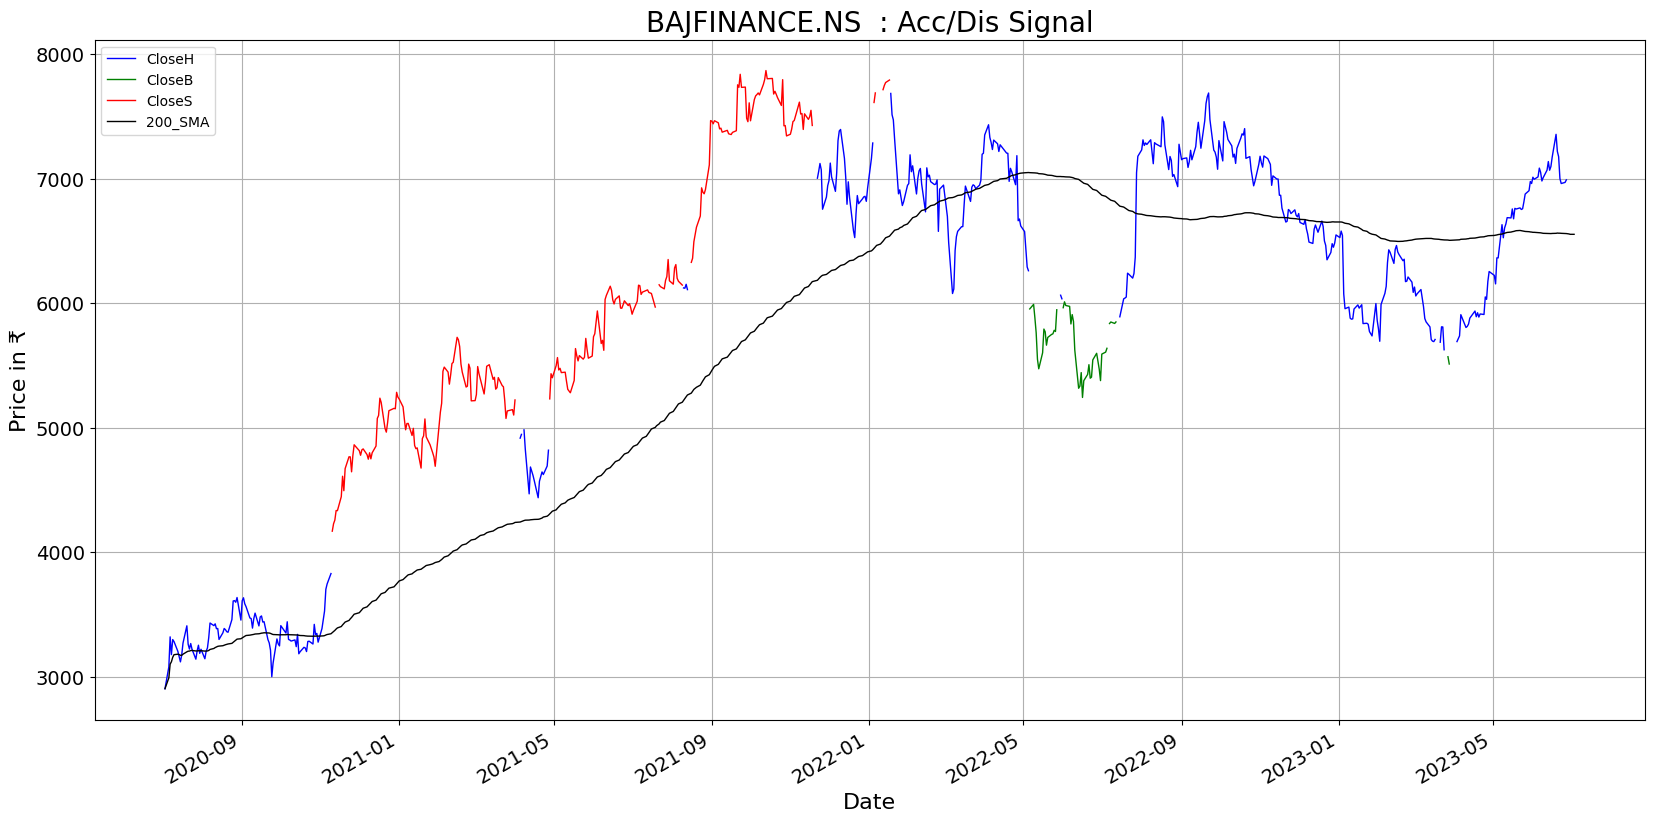

In [20]:
stock_symbol = 'BAJFINANCE.NS'
plot_acc_dis_signals(stock_symbol)